In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from datetime import datetime



In [ ]:
#save my life
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#training parameters
nb_experiments = 3
nb_epochs_per_acquisition = 100
batch_size = 30
eval_batch_size=256
validation_set_size = 100
dropout_samples = 100
acquisition_iters = 100
points_acquire = 10

#model parameters
nb_filters = 32
nb_classes = 10
filter_size = 4
pool_size = 2
dense_size = 128
dropout_prob_1 = 0.25
dropout_prob_2 = 0.5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#define our model:
class BayesianCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, nb_filters, kernel_size=filter_size, padding=0)
    self.conv2 = nn.Conv2d(nb_filters, nb_filters, kernel_size=filter_size, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=pool_size)
    self.dropout1 = nn.Dropout(p=dropout_prob_1)

    self.full1 = nn.Linear(32 * 11 * 11, dense_size)
    self.dropout2 = nn.Dropout(p=dropout_prob_2)
    self.full2 = nn.Linear(dense_size, nb_classes)

  def features(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    x = F.relu(self.full1(x))
    x = self.dropout2(x)
    return x

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    x = F.relu(self.full1(x))
    x = self.dropout2(x)
    x = self.full2(x)
    return x


In [ ]:
@torch.no_grad()
def eval_model(model, X_test, y_test, device):
  model = model.to(device)
  model.eval()

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  output = model(X_test)
  pred = output.argmax(dim=1)
  acc = (pred == y_test).float().mean().item()
  return acc


#model training loop
def train_model(model, X, y, X_val, y_val, optimizer, criterion, batch_size, device, nb_epochs):
  model.train()
  model.to(device)

  dloader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=batch_size)
  patience = 10
  best_val_acc = -1.0
  bad_epochs = 0
  best_state = None

  for epoch in range(nb_epochs):
    model.train()
    train_loss = 0
    for x, y in dloader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * len(x)
    train_loss /= len(X)

    verbose = False

    if verbose:
     print(f"Epoch {epoch+1}: Train Loss: {train_loss}")

    early_stopping = True
    if early_stopping:
      val_acc = eval_model(model, X_val, y_val, device)
      model.train()
      if verbose:
        print(f"Epoch {epoch+1}: Val Acc: {val_acc}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        bad_epochs = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
      else:
        bad_epochs += 1
        if bad_epochs >= patience:
          #print(f"Early stopping at epoch {epoch+1}")
          break

  if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


  return model

In [ ]:
#get the datasets
transform = transforms.Compose([
    transforms.ToTensor(),
])
train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X = torch.stack([train[i][0] for i in range(len(train))])
y = torch.tensor([train[i][1] for i in range(len(train))])

X_test = torch.stack([test[i][0] for i in range(len(test))])
y_test = torch.tensor([test[i][1] for i in range(len(test))])


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.88MB/s]


In [ ]:
print(X_test.shape)
print(X.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])


In [ ]:
def sample_from_pool(X_pool, y_pool):
  indices = []
  for label in range(nb_classes):
    class_indices = (y_pool == label).nonzero(as_tuple=True)[0]
    class_indices = class_indices[torch.randperm(len(class_indices))]
    indices.append(class_indices[:2])
  return torch.cat(indices, dim=0)


In [ ]:
@torch.no_grad()
def compute_entropy(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.train()
  eps = 1e-8

  X_pool_red = X_pool_red.to(device)
  N = X_pool_red.size(0)
  sum_probs = torch.zeros((N, nb_classes), device=device)

  for _ in range(dropout_samples):
    logits = model(X_pool_red)
    probs = torch.softmax(logits, dim=1)
    sum_probs += probs

  mean_probs = sum_probs / dropout_samples
  predictive_entropy = -(mean_probs * (mean_probs + eps).log()).sum(dim=1)

  return predictive_entropy

In [ ]:
def compute_random_acquisition(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  return torch.rand(X_pool_red.size(0))

In [ ]:
@torch.no_grad()
def compute_bald(model, X_pool_red, device, dropout_samples=100, batch_size=10, nb_classes=10):
  model = model.to(device)
  model.train()
  eps = 1e-8

  X_pool_red = X_pool_red.to(device)
  N = X_pool_red.size(0)

  sum_probs = torch.zeros((N, nb_classes), device=device)
  sum_entropy = torch.zeros((N,), device=device)

  for _ in range(dropout_samples):
    logits = model(X_pool_red)
    probs = torch.softmax(logits, dim=1)

    sum_probs += probs
    sum_entropy += -(probs * (probs + eps).log()).sum(dim=1)

  mean_probs = sum_probs / dropout_samples
  expected_entropy = sum_entropy / dropout_samples
  predictive_entropy = -(mean_probs * (mean_probs + eps).log()).sum(dim=1)

  bald = predictive_entropy - expected_entropy
  return bald


In [ ]:
@torch.no_grad()
def compute_variation_ratio(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.train()

  N = X_pool_red.size(0)
  X_pool_red = X_pool_red.to(device)
  sum_probs = torch.zeros((N, nb_classes), device=device)

  for _ in range(dropout_samples):
    logits = model(X_pool_red)
    probs = torch.softmax(logits, dim=1)

    sum_probs += probs

  mean_probs = sum_probs / dropout_samples
  max_conf = mean_probs.max(dim=1).values
  return 1.0 - max_conf

In [ ]:
@torch.no_grad()
def compute_mean_std(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.train()


  N = X_pool_red.size(0)
  X_pool_red = X_pool_red.to(device)
  sum_probs = torch.zeros((N, nb_classes), device=device)
  sum_probs_squared = torch.zeros((N, nb_classes), device=device)

  for _ in range(dropout_samples):
    logits = model(X_pool_red)

    probs = torch.softmax(logits, dim=1)
    probs_squared = probs ** 2
    sum_probs += probs
    sum_probs_squared += probs_squared

  mean_probs = sum_probs / dropout_samples
  mean_probs_squared = sum_probs_squared / dropout_samples
  std_probs = (mean_probs_squared - mean_probs ** 2).sqrt()
  mean_std = torch.mean(std_probs,dim=1)
  return mean_std


In [ ]:
def run_experiment(X, y, X_test, y_test, acquisitions = None):
  perm = torch.randperm(len(X))
  X = X[perm]
  y = y[perm]
  X_valid = X[:validation_set_size]
  y_valid = y[:validation_set_size]
  X_pool_orig = X[validation_set_size:]
  y_pool_orig = y[validation_set_size:]

  accs_for_acquisitons = [[] for _ in range(len(acquisitions))]
  for acq in range(len(acquisitions)):

    print(f'Creating training dataset')
    train_idx = sample_from_pool(X_pool_orig, y_pool_orig)
    X_train = X_pool_orig[train_idx]
    y_train = y_pool_orig[train_idx]

    mask = torch.ones(len(X_pool_orig), dtype=torch.bool)
    mask[train_idx] = False
    X_pool = X_pool_orig[mask]
    y_pool = y_pool_orig[mask]


    print(f'Active learning: running for {acquisitions[acq][1]}')
    acq_name = acquisitions[acq][1]
    acq_func = acquisitions[acq][0]
    md = None
    accs = []

    for i in range(acquisition_iters):
      if i % 10 == 0:
        print(f'Starting acquisition iteration {i}')

      modelAct = BayesianCNN()
      optimizer = torch.optim.Adam(modelAct.parameters(), lr=0.001,weight_decay=0.001)
      criterion = nn.CrossEntropyLoss()

      #train on the current training set
      modelAct = train_model(modelAct, X_train, y_train, X_valid, y_valid, optimizer, criterion, batch_size=batch_size, device=device, nb_epochs=nb_epochs_per_acquisition)

      #get BALD for all or almost all pool points?
      idx = torch.randperm(X_pool.size(0))[:1000]
      X_pool_red = X_pool[idx]
      y_pool_red = y_pool[idx]

      score = acq_func(modelAct, X_pool_red, device, dropout_samples, batch_size=eval_batch_size, nb_classes=10)

      Queries = 10

      topk_in_red = torch.topk(score, k=Queries).indices.to("cpu")
      chosen_idx = idx[topk_in_red]

      X_train = torch.cat([X_train, X_pool[chosen_idx]], dim=0)
      y_train = torch.cat([y_train, y_pool[chosen_idx]], dim=0)

      mask = torch.ones(X_pool.size(0), dtype=torch.bool)
      mask[chosen_idx] = False
      X_pool = X_pool[mask]
      y_pool = y_pool[mask]

      acc = eval_model(modelAct, X_test, y_test, device)
      modelAct.train()
      accs.append((acc, X_train.shape[0] - Queries))
      print(f'Accuracy: {acc}')
      md = modelAct


    now = datetime.now()
    save_path = "/content/drive/MyDrive/" + str(now.hour) + str(now.minute) + acq_name + "bayesian_cnn_mnist.pt"
    torch.save(md.state_dict(), save_path)

    accs_for_acquisitons[acq] = accs

  return accs_for_acquisitons

# Entry Point

In [ ]:
import matplotlib.pyplot as plt
import json

In [ ]:
#as in the paper, we repeat 3 times
funcs = [[compute_bald, "bald"]]# [compute_variation_ratio, "variation_ratio"], [compute_entropy, "entropy"], [compute_mean_std, "mean"], [compute_random_acquisition, "random"]]

results1 = run_experiment(X, y, X_test, y_test, funcs)
#results2 = run_experiment(X, y, X_test, y_test, funcs)
#results3 = run_experiment(X, y, X_test, y_test, funcs)

# average them
avg_results = []
for i in range(5):
  avg_results.append([])
  for j in range(acquisition_iters):
    avg_results[i].append([(results1[i][j][0] + results2[i][j][0] + results3[i][j][0]) / 3, results1[i][j][1]])

#alternatively, read from file (this is on my own google drive)
#with open("/content/drive/MyDrive/results_all.json", "r") as f:
#  avg_results = json.load(f)

Creating training dataset
Active learning: running for bald
Starting acquisition iteration 0
Accuracy: 0.6032999753952026
Accuracy: 0.6491999626159668
Accuracy: 0.6931999921798706
Accuracy: 0.6523000001907349
Accuracy: 0.724399983882904
Accuracy: 0.7419999837875366
Accuracy: 0.78329998254776
Accuracy: 0.7419999837875366


KeyboardInterrupt: 

In [ ]:

#alternatively, read from file (this is on my own google drive)
with open("/content/drive/MyDrive/results_all_wd.json", "w") as f:
  json.dump(avg_results, f)

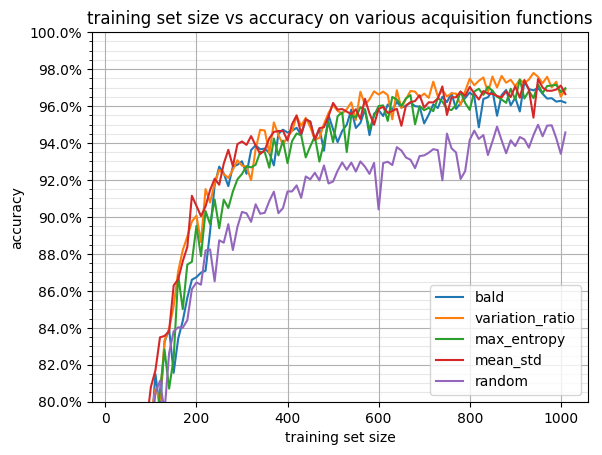

In [ ]:
from matplotlib.ticker import MultipleLocator, PercentFormatter
names =  ["bald","variation_ratio", "max_entropy","mean_std","random"]
for i in range(5):
  accs = avg_results[i]
  plt.plot([acc[1] for acc in accs], [acc[0] for acc in accs], label=names[i])


ax = plt.gca()

ax.set_ylim(0.8, 1.00)

ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

ax.grid(True, which="major")
ax.grid(True, which="minor", alpha=0.3)

plt.title("training set size vs accuracy on various acquisition functions")
plt.xlabel("training set size")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [ ]:
#make table at what amount of examples methods pass error thresholds
thresholds10_5 = [[None, None] for i in range(5)]
for i in range(5):
  iter10 = 0
  iter5 = 0
  while thresholds10_5[i][0] is None and iter10 < acquisition_iters:
    if avg_results[i][iter10][0] == 0.90:
      thresholds10_5[i][0] = avg_results[i][iter10][1]
    elif avg_results[i][iter10][0] > 0.90:
      thresholds10_5[i][0] = (avg_results[i][iter10][1] + avg_results[i][iter10 - 1][1]) / 2
    else:
      iter10 += 1

  while thresholds10_5[i][1] is None and iter5 < acquisition_iters:
    if avg_results[i][iter5][0] == 0.95:
      thresholds10_5[i][1] = avg_results[i][iter5][1]
    elif avg_results[i][iter5][0] > 0.95:
      thresholds10_5[i][1] = (avg_results[i][iter5][1] + avg_results[i][iter5 - 1][1]) / 2
    else:
      iter5 += 1

for i in range(5):
  print(names[i], thresholds10_5[i])

bald [235.0, 435.0]
variation_ratio [195.0, 365.0]
entropy [215.0, 485.0]
mean [185.0, 405.0]
random [295.0, None]


# Deterministic versions

Override acquisition functions to their simple deterministic variants - note that entropy based stuff will default to all zeroes - there is no entropy in dirac delta.

In [ ]:
@torch.no_grad()
def compute_entropy_deterministic(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.eval()
  eps = 1e-8

  X_pool_red = X_pool_red.to(device)
  N = X_pool_red.size(0)
  sum_probs = torch.zeros((N, nb_classes), device=device)


  logits = model(X_pool_red)
  probs = torch.softmax(logits, dim=1)
  sum_probs += probs

  predictive_entropy = -(sum_probs * (sum_probs + eps).log()).sum(dim=1)

  return predictive_entropy

In [ ]:
@torch.no_grad()
def compute_bald_deterministic(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.train()
  eps = 1e-8


  N = X_pool_red.size(0)
  X_pool_red = X_pool_red.to(device)
  sum_probs = torch.zeros((N, nb_classes), device=device)
  sum_entropy = torch.zeros((N,), device=device)

  logits = model(X_pool_red)
  probs = torch.softmax(logits, dim=1)

  sum_probs += probs
  sum_entropy += -(probs * (probs + eps).log()).sum(dim=1)

  predictive_entropy = -(sum_probs * (sum_probs + eps).log()).sum(dim=1)

  bald = predictive_entropy - sum_entropy
  return bald

In [ ]:
@torch.no_grad()
def compute_variation_ratio_deterministic(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.train()

  N = X_pool_red.size(0)
  X_pool_red = X_pool_red.to(device)
  sum_probs = torch.zeros((N, nb_classes), device=device)

  logits = model(X_pool_red)

  probs = torch.softmax(logits, dim=1)
  sum_probs += probs

  max_conf = sum_probs.max(dim=1).values
  return 1.0 - max_conf

In [ ]:
@torch.no_grad()
def compute_mean_std_deterministic(model, X_pool_red, device, dropout_samples=100, batch_size=eval_batch_size, nb_classes=10):
  model = model.to(device)
  model.train()

  N = X_pool_red.size(0)
  X_pool_red = X_pool_red.to(device)
  sum_probs = torch.zeros((N, nb_classes), device=device)
  sum_probs_squared = torch.zeros((N, nb_classes), device=device)

  logits = model(X_pool_red)

  probs = torch.softmax(logits, dim=1)
  probs_squared = probs ** 2

  sum_probs += probs
  sum_probs_squared += probs_squared

  std_probs = (sum_probs_squared - sum_probs ** 2).sqrt()
  mean_std = torch.mean(std_probs,dim=1)
  return mean_std

In [ ]:
funcs = [[compute_bald_deterministic, "bald deterministic"], [compute_variation_ratio_deterministic, "variation_ratio deterministic"], [compute_entropy_deterministic, "entropy determinstic"], [compute_mean_std_deterministic, "mean deterministic"]]
resultsd1 = run_experiment(X, y, X_test, y_test, funcs)
resultsd2 = run_experiment(X, y, X_test, y_test, funcs)
resultsd3 = run_experiment(X, y, X_test, y_test, funcs)

avg_resultsd = []
for i in range(4):
  avg_resultsd.append([])
  for j in range(acquisition_iters):
    avg_resultsd[i].append([(resultsd1[i][j][0] + resultsd2[i][j][0] + resultsd3[i][j][0]) / 3, resultsd1[i][j][1]])

Creating training dataset
Active learning: running for bald deterministic
Starting acquisition iteration 0
Accuracy: 0.5121
Accuracy: 0.5972
Accuracy: 0.6977
Accuracy: 0.7205
Accuracy: 0.7151
Accuracy: 0.6892
Accuracy: 0.7369
Accuracy: 0.7247
Accuracy: 0.7778
Accuracy: 0.7931
Starting acquisition iteration 10
Accuracy: 0.7915
Accuracy: 0.8423
Accuracy: 0.7866
Accuracy: 0.8309
Accuracy: 0.8341
Accuracy: 0.8286
Accuracy: 0.8378
Accuracy: 0.8474
Accuracy: 0.856
Accuracy: 0.8675
Starting acquisition iteration 20
Accuracy: 0.872
Accuracy: 0.8782
Accuracy: 0.8862
Accuracy: 0.8956
Accuracy: 0.8561
Accuracy: 0.8937
Accuracy: 0.8687
Accuracy: 0.9152
Accuracy: 0.8801
Accuracy: 0.9044
Starting acquisition iteration 30
Accuracy: 0.8922
Accuracy: 0.9014
Accuracy: 0.9077
Accuracy: 0.9128
Accuracy: 0.9097
Accuracy: 0.9225
Accuracy: 0.9222
Accuracy: 0.9214
Accuracy: 0.9295
Accuracy: 0.9209
Starting acquisition iteration 40
Accuracy: 0.9258
Accuracy: 0.9232
Accuracy: 0.9319
Accuracy: 0.9364
Accuracy: 0

In [ ]:
with open("/content/drive/MyDrive/results_deterministic_first_wd.json", "w") as f:
  json.dump(resultsd1, f)
with open("/content/drive/MyDrive/results_deterministic_second_wd.json", "w") as f:
  json.dump(resultsd2, f)
with open("/content/drive/MyDrive/results_deterministic_third_wd.json", "w") as f:
  json.dump(resultsd3, f)
with open("/content/drive/MyDrive/results_deterministic_all_wd.json", "w") as f:
  json.dump(avg_resultsd, f)

In [ ]:
import numpy as np

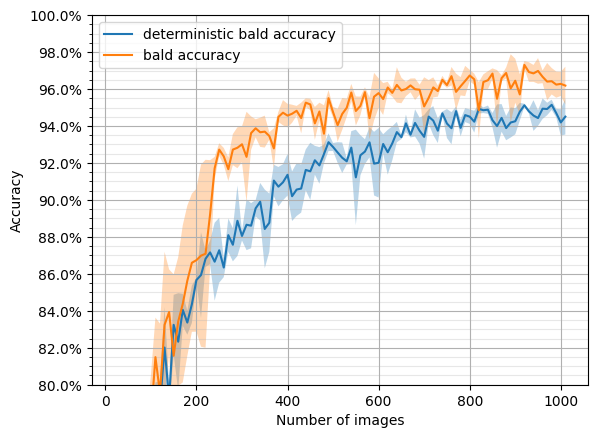

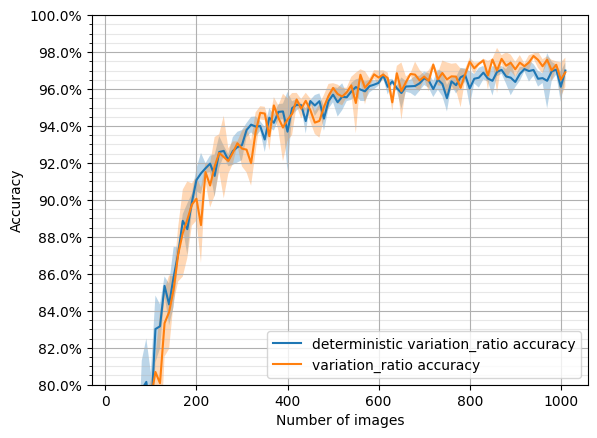

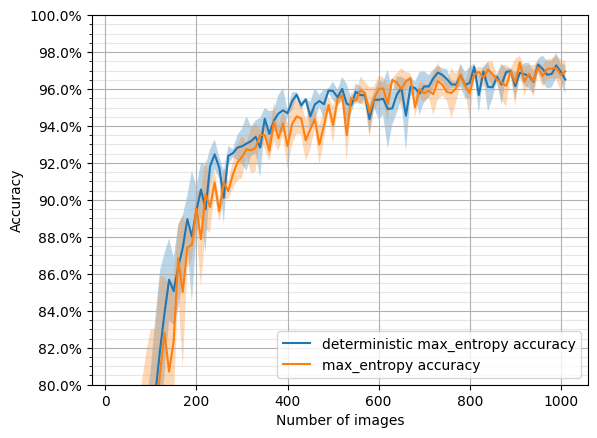

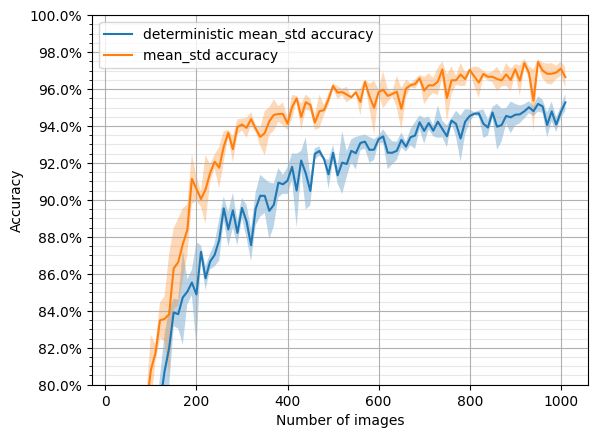

In [ ]:
for i in range(4):
  labels = [avg_resultsd[i][j][1] for j in range(acquisition_iters)]
  det_mean = [avg_resultsd[i][j][0] for j in range(acquisition_iters)]
  det_std = np.array([[resultsd1[i][j][0], resultsd2[i][j][0], resultsd3[i][j][0]] for j in range(acquisition_iters)]).std(axis=1)
  det_upper = det_mean + det_std
  det_lower = det_mean - det_std

  rand_mean = [avg_results[i][j][0] for j in range(acquisition_iters)]
  rand_std = np.array([[results1[i][j][0], results2[i][j][0], results3[i][j][0]] for j in range(acquisition_iters)]).std(axis=1)
  rand_upper = rand_mean + rand_std
  rand_lower = rand_mean - rand_std


  plt.figure()
  plt.plot(labels, det_mean, label=f"deterministic {names[i]} accuracy")
  plt.fill_between(labels, det_lower, det_upper, alpha=0.3)
  plt.plot(labels, rand_mean, label=f"{names[i]} accuracy")
  plt.fill_between(labels, rand_lower, rand_upper, alpha=0.3)

  ax = plt.gca()

  ax.set_ylim(0.80, 1.00)

  ax.yaxis.set_major_locator(MultipleLocator(0.02))
  ax.yaxis.set_minor_locator(MultipleLocator(0.005))
  ax.yaxis.set_major_formatter(PercentFormatter(1.0))

  ax.grid(True, which="major")
  ax.grid(True, which="minor", alpha=0.3)


  plt.xlabel("Number of images")
  plt.ylabel("Accuracy")
  #plt.grid(True, alpha=0.3)
  plt.legend()
  plt.show()

